In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

2026-01-15 15:35:09.510937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768491309.707050      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768491309.765537      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768491310.253454      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768491310.253505      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768491310.253508      55 computation_placer.cc:177] computation placer alr

In [4]:
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

X = np.concatenate((x_train_full, x_test_full), axis=0)
y = np.concatenate((y_train_full, y_test_full), axis=0)

indices = np.random.permutation(len(X))
X, y = X[indices], y[indices]

train_size = int(0.8 * len(X))
val_size = int(0.1 * len(X))

x_train = X[:train_size]
y_train = y[:train_size]

x_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

x_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

170498071/170498071 [==============================] - 3s 0us/step


In [10]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .map(preprocess).shuffle(1000).batch(BATCH_SIZE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)) \
    .map(preprocess).batch(BATCH_SIZE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(preprocess).batch(BATCH_SIZE)


### Architecture Design Rationale

- A custom CNN is designed instead of transfer learning.
- Channel-wise attention (SE blocks) are added to emphasize informative features.
- Global Average Pooling reduces overfitting.

In [11]:
def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]

    x = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    x = tf.keras.layers.Dense(channels // ratio, activation='relu')(x)
    x = tf.keras.layers.Dense(channels, activation='sigmoid')(x)

    x = tf.keras.layers.Reshape((1,1,channels))(x)
    return tf.keras.layers.Multiply()([input_tensor, x])

In [12]:
def build_custom_attention_cnn():
    inputs = tf.keras.layers.Input(shape=(32,32,3))

    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = se_block(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = se_block(x)
    x = tf.keras.layers.MaxPooling2D()(x)

    x = tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = se_block(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

    return tf.keras.Model(inputs, outputs)

In [13]:
model_lvl3 = build_custom_attention_cnn()

In [14]:
model_lvl3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
history_lvl3 = model_lvl3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40
)

Epoch 1/40


I0000 00:00:1768491477.730930     120 cuda_dnn.cc:529] Loaded cuDNN version 91002
I0000 00:00:1768491480.167869     119 service.cc:152] XLA service 0x799638250c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768491480.167914     119 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768491480.430510     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 [==============================] - 15s 9ms/step - loss: 1.3133 - accuracy: 0.5264 - val_loss: 1.1915 - val_accuracy: 0.5570
Epoch 2/40
750/750 [==============================] - 6s 9ms/step - loss: 0.9049 - accuracy: 0.6817 - val_loss: 1.1794 - val_accuracy: 0.5905
Epoch 3/40
750/750 [==============================] - 6s 9ms/step - loss: 0.7217 - accuracy: 0.7479 - val_loss: 0.8262 - val_accuracy: 0.7165
Epoch 4/40
750/750 [==============================] - 7s 9ms/step - loss: 0.6044 - accuracy: 0.7916 - val_loss: 0.8924 - val_accuracy: 0.7033
Epoch 5/40
750/750 [==============================] - 7s 9ms/step - loss: 0.5067 - accuracy: 0.8257 - val_loss: 0.7784 - val_accuracy: 0.7457
Epoch 6/40
750/750 [==============================] - 7s 9ms/step - loss: 0.4382 - accuracy: 0.8482 - val_loss: 0.8315 - val_accuracy: 0.7228
Epoch 7/40
750/750 [==============================] - 7s 9ms/step - loss: 0.3685 - accuracy: 0.8739 - val_loss: 0.6661 - val_accuracy: 0.7867
Epoch 8/40
750/7

In [16]:
test_loss, test_acc = model_lvl3.evaluate(test_ds)
print(f"Level 3 Test Accuracy: {test_acc * 100:.2f}%")

94/94 [==============================] - 0s 4ms/step - loss: 1.1859 - accuracy: 0.7910
Level 3 Test Accuracy: 79.10%


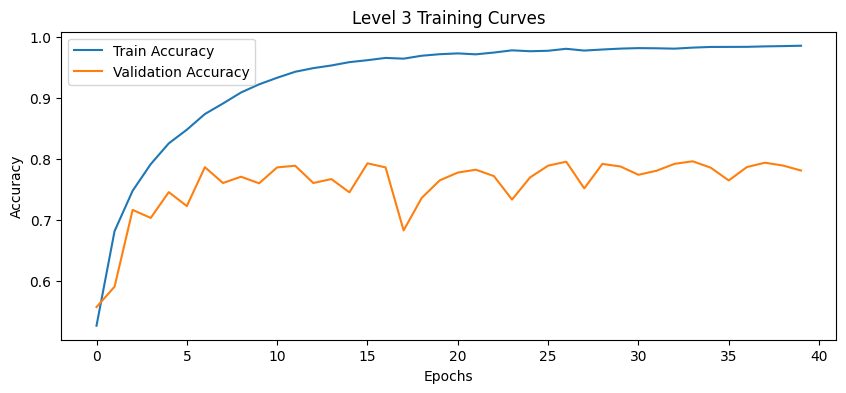

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

plt.plot(history_lvl3.history['accuracy'], label='Train Accuracy')
plt.plot(history_lvl3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Level 3 Training Curves')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import classification_report
import numpy as np

y_true, y_pred = [], []

for images, labels in test_ds:
    preds = model_lvl3.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(
    y_true, y_pred,
    target_names=[
        'airplane','car','bird','cat','deer',
        'dog','frog','horse','ship','truck'
    ]
))

2/2 [==============================] - 0s 53ms/step
              precision    recall  f1-score   support

    airplane       0.72      0.89      0.79       612
         car       0.90      0.88      0.89       644
        bird       0.79      0.73      0.76       613
         cat       0.69      0.64      0.67       573
        deer       0.85      0.64      0.73       589
         dog       0.70      0.71      0.70       582
        frog       0.82      0.84      0.83       627
       horse       0.73      0.87      0.79       535
        ship       0.94      0.82      0.87       636
       truck       0.81      0.87      0.84       589

    accuracy                           0.79      6000
   macro avg       0.79      0.79      0.79      6000
weighted avg       0.80      0.79      0.79      6000

